<br>

<center> <strong> <font face="Courier New" size=5> Reinforcement Learning </font> </strong> </center>
<br>
<center>  <strong> <font face="Courier New" size=6 color='#2E86C1'> Taller 3 - Algoritmos de aprendizaje por refuerzo tabulares</font> </strong> </center>

<br>
<center> <p> Docente: Fernando Enrique Lozano Martinez </p>
 <p> 
 Estudiantes: <br>
 Manuela Viviana Chacón Chamorro <br>
 Juan Ivan Cubillos Garay </p>
</center>

<br> 
<p> IELE <br> 
Facultad de Ingeniería <br>
Universidad de los Andes <br>
2023
</p>

---

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Semilla para los aleatorios 
np.random.seed(202303)
random.seed(202303)

# Configuración general de gráficas 
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Introducción



<p align="justify">
En el juego de escaleras y serpientes planteado en la siguiente figura se considera un tablero de 100 posiciones. En cada posición el jugador debe decidir si desea avanzar o retroceder, a continuación se lanza un dado y se avanza o retrocede el número de casillas indicadas por el dado. La meta del jugador es ganar la partida, esto ocurre cuando se llega a una de las casillas marcadas con el emoticon azul. Además, el agente debe evitar perder evadiendo las casillas marcadas con emoticones rojos. Si el agente cae en la cabeza de una serpiente será enviado al estado señalado por la cola de esa serpiente, en el caso que el agente quede en el estado de la base de una escalera será transportado a la cima de esta. Otro aspecto importante a considerar en la dinámica del juego son los rebotes, cuando el agente supere el límite de los estados bordes (100) o (1) se rebota avanzando en la dirección contraria. 

<p align="justify">
Este juego puede ser modelado como un Proceso de Decisión de Markov (MDP, por sus siglas en inglés), donde se pueden modelar las probabilidades de transición y las recompensas asociadas con cada estado y acción. Sin embargo, obtener estas probabilidades puede ser una tarea difícil, ya que en este juego se deben considerar 60.000 probabilidades diferentes (combinando estados, acciones y recompensas). En muchos casos de aplicaciones reales, no es factible modelar explícitamente el MDP, por lo que se deben recurrir a otros métodos para estimar la mejor política de manera indirecta, en lugar de resolver las Ecuaciones de Bellman directamente. 

<p align="justify">
Una forma de abordar esta problemática es a través del enfoque de los métodos Montecarlo. Estos métodos estiman la función de valor de acción-estado ($Q(s,a)$) promediando los retornos obtenidos al realizar múltiples episodios. Con estas estimaciones, se pueden aplicar mecanismos de iteración de política, alternando entre estimación y mejora. Otro enfoque para resolver el problema en ausencia de las probabilidades del MDP son los métodos de Diferencias Temporales, como SARSA y Q-learning. Estos métodos actualizan las estimaciones de la función $Q(s,a)$ en función del estado siguiente, utilizando la técnica conocida como "boostrapping". En este taller se implementarán los métodos Montecarlo, SARSA y Q-learning para abordar el juego presentado en la figura y encontrar una política óptima de movimiento. A lo largo del taller se presentará el concepto teórico de los métodos, la implementación computacional, la configuración de hiperparámetros y la evaluación del desempeño mediante la realización de algunas partidas.

<center>
<div>
<img src="https://drive.google.com/uc?export=view&id=1eXbLYbNaNxlWGkTVij0QKZvff3h7yKvi" width="500"/>
</div>
</center>


# Formulación de los elementos del juego

## Estados

Los estados para este juego serán las posiciones del tablero.

$$S^+ = \{s | \ s \in \mathbb{Z}, 1 \leq s \leq 100\}$$

La notación $S^+$ indica que este conjunto también contiene a los estados finales, los cuales son las posiciones donde están los emoticones azules o rojos.

## Definición de recompensas

Se considera que las recompensas para el juego pueden ser $R = \{1, -1, 0\}$. La recompensa $1$ se dará cuando el agente llegue a la casilla de ganar, $-1$ en la casilla perder y 0 en cualquier otro estado del tablero. 

## Acciones

Las acciones serán **Avanzar** o **Retroceder**, se debe definir tan pronto se llegue al estado e indicarán si se avanza o retrocede el número de casillas definidas por el dado.

----
<p align="justify">
A continuación se presentan las funciones que corresponden a la inicialización de los parámetros del tablero de juego, incluyendo los elementos más relevantes, como las posiciones de victoria y derrota, así como las dinámicas de las serpientes y las escaleras. Estas funciones son esenciales para la configuración inicial del juego y aseguran que todas las variables relevantes estén definidas correctamente antes de comenzar el juego.
 

In [2]:
def parametersBoard(indexRewardWin, indexRewardLoss):
    # Esta función inicializa el tablero y los elementos del MDP
    # Parámetros 
    # indexRewardWin = lista con los estados en los cuales el jugador gana
    # indexRewardLoss = lista con los estados en los cuales el jugador pierde

    # Retorna
    # boardState = lista de estados
    # rewardBoard = lista de recompensas observadas para cada estado rewardBoard[state - 1]
    # rewards = Conjunto de recompensas
    # actionAvailable = acciones disponibles
    # gameOver lista que indica si el juego ha sido finalizado 
    # headSnakes = estados con cabeza de serpiente
    # tailSnakes = estados con colas de serpientes
    # floorLadders = estados con bases de escaleras
    # ceilLadders = estados con cimas de escaleras 

    
    boardState = range(1,101) # Inicialización tablero de estados 
    actionAvailable = ['A', 'R'] # Acciones disponibles A = avanzar, R = retroceder
    
    rewards = [1, -1, 0] # Conjunto de recompensas

    # Creacion tablero de recompensas 
    rewardBoard = np.zeros((100,)) 
    for i in indexRewardWin: rewardBoard[i-1] = 1
    for j in indexRewardLoss: rewardBoard[j-1] = -1
    
    # Creacion lista de verificación si el juego ha terminado 
    gameOver = [True if reward != 0 else False for i, reward in enumerate(rewardBoard) ]
    
    # Posiciones serpientes
    headSnakes = [44, 46, 48, 52, 55, 59, 64, 69, 73, 83, 92, 95, 98]
    tailSnakes =  [22, 5, 9, 11, 7, 17, 36, 33, 1, 19, 51, 24, 28]

    # Posiciones escaleras  
    floorLadders = [8, 21, 43, 50, 54, 62, 66, 80]
    ceilLadders = [26, 82, 77, 91, 93, 96, 87, 100]

    return boardState, rewardBoard, rewards, actionAvailable, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders

In [3]:
indexRewardWin = [80, 100]
indexRewardLoss = [23, 37, 45, 67, 89]

boardState, rewardBoard, rewards, actionAvailable, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders  = parametersBoard(indexRewardWin, indexRewardLoss)

# Interacción con el juego

<p align="justify">
La siguiente función simula la interacción con el juego introduciendo la posición actual de un jugador, la acción que desea ejecutar, las posiciones de escaleras y las serpientes y las recompensas del tablero. Esta función simula el lanzamiento del dado desde la  posición establecida y retorna la posición final, la recompensa observada en la transición y una bandera que indica si se finalizó el juego (perdiendo o ganando la partida).

In [4]:
def playGame(s,a, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard):
  # Esta funcion permite interactuar con el MDP como jugador
  # Recibe por parametro:
  # S: Estado actual del jugador 
  # a: Accion tomada por el jugador (Retroceder o avanzar)
  # gameOver: Boleano que identifica si el juego acabo o sigue.
  # headSnakes: Lista con las casillas en las que hay una cabeza de serpiente
  # tailSnakes: Lista con las casillas en las que hay una cola de serpiente
  # floorLadders:Lista con las casillas en las que hay un inicio de escaleras
  # ceilLadders:Lista con las casillas en las que hay un final de escaleras
  # rewardBoard: Recompensas de las casillas del tablero.
  
  if gameOver[s-1]:
    return s, 0, True 
  
  else:
    dice = np.random.randint(1, 7)
    if a == 'A':
        sNew = s + dice
        if sNew > 100: sNew = 200 - sNew
        if sNew in headSnakes: sNew = tailSnakes[headSnakes.index(sNew)]
        if sNew in floorLadders: sNew = ceilLadders[floorLadders.index(sNew)]
        
    if a == 'R':
        sNew = s - dice
        if sNew < 1: sNew = 2 + abs(sNew)
        if sNew in headSnakes: sNew = tailSnakes[headSnakes.index(sNew)]
        if sNew in floorLadders: sNew = ceilLadders[floorLadders.index(sNew)]

  R = rewardBoard[sNew - 1]
  return sNew, R, gameOver[sNew-1]

En la siguiente celda se presenta un ejemplo, partiendo de la posición y ejecutando la acción 'A' (avanzar) se puede observar la nueva posición del jugador en el tablero, la recompensa lograda y si se término la partida. 

In [5]:
S = 26
A = 'A'

S1, R, flagGameOver = playGame(S, A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

if flagGameOver:
  print(f'Para el jugador que comenzo en la posición {S} y ejecuto la acción {A}:\n* El nuevo estado es {S1}, la recompensa es {R} y el juego Finalizo')
else:
  print(f'Para el jugador que comenzo en la posición {S} y ejecuto la acción {A}:\n* El nuevo estado es {S1}, la recompensa es {R} y el juego Continua')

Para el jugador que comenzo en la posición 26 y ejecuto la acción A:
* El nuevo estado es 32, la recompensa es 0.0 y el juego Continua


<p align="justify">
La función que se propone a continuación realiza la simulación de varias partidas, para cada partida iniciando desde la posición 1 del tablero realiza un juego siguiendo una política deterministica. Al finalizar la función retorna la duración en pasos de cada partida jugada y el porcentaje de partidas ganadas.

In [6]:
def playPolicy(policy, numberGames,
               gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard):

  # Esta funcion permite interactuar con el MDP como jugador realizando varias partidas del juego
  # Recibe por parametro:
  # policy: Política determinística en forma de diccionario para cada estado
  # numberGames: Número de partidas a jugar 
  # gameOver: Boleano que identifica si el juego acabo o sigue.
  # headSnakes: Lista con las casillas en las que hay una cabeza de serpiente
  # tailSnakes: Lista con las casillas en las que hay una cola de serpiente
  # floorLadders:Lista con las casillas en las que hay un inicio de escaleras
  # ceilLadders:Lista con las casillas en las que hay un final de escaleras
  # rewardBoard: Recompensas de las casillas del tablero. 

  setsWin = 0
  lenSets = []
  for _ in range(numberGames):
    steps = 0
    S = 1
    while True:
      A = policy[S]
      SNew, R, flag = playGame(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
      steps += 1
      S = SNew
      if flag or steps >= 10000: break;
    if R == 1: setsWin += 1
    lenSets.append(steps)
  return lenSets, setsWin/numberGames

Por ejemplo, a continuación se construye la política que siempre avanza y se juegan 1000 partidas, luego se indica el porcentaje de partidas ganadas y graficas del comportamiento de la longitud de las partidas. 

In [7]:
policyAdvance = {}
policyAdvance = {s:'A' for s in boardState}
numberEpisodics = 1000
lenSets, percentageWin = playPolicy(policyAdvance, 1000,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

In [8]:
print(f'Utilizando la política que siempre avanza en {numberEpisodics} epsidios se gana el {percentageWin*100:0.2f}% de las veces')

Utilizando la política que siempre avanza en 1000 epsidios se gana el 11.20% de las veces


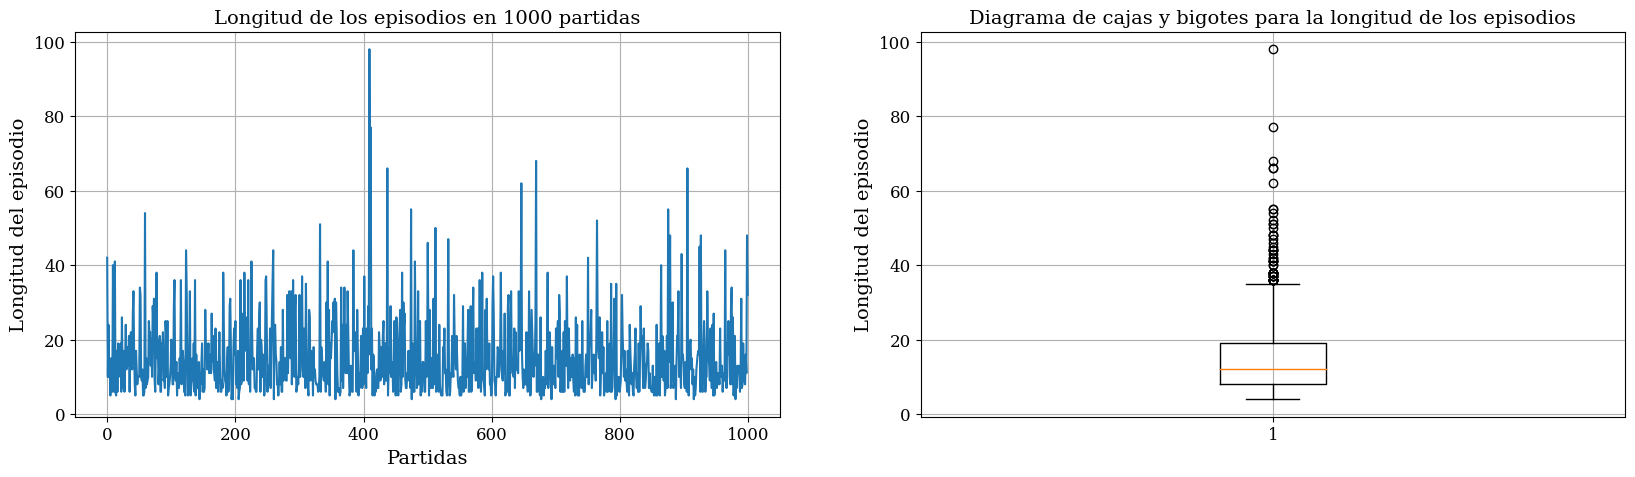

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# Configuración aspecto de la gráfica de la longitud de los episodios
ax[0].plot(lenSets)   
ax[0].set_title(f'Longitud de los episodios en {numberEpisodics} partidas', fontsize = 14)
ax[0].set_ylabel('Longitud del episodio', fontsize = 14)
ax[0].set_xlabel('Partidas', fontsize = 14)
ax[0].grid()

ax[1].boxplot(lenSets)
# Configuración aspecto de la gráfica boxplot
ax[1].set_title(f'Diagrama de cajas y bigotes para la longitud de los episodios', fontsize = 14)
ax[1].set_ylabel('Longitud del episodio', fontsize = 14)
ax[1].set_xlabel('', fontsize = 14)
ax[1].grid()

plt.show()

# Política óptima con Montecarlo (Off-Policy)

<p align="justify">
El método de control Off Policy de Montecarlo se basa en la utilización de dos políticas: la política $b$ de comportamiento (soft) y la política $\pi$ que se aprende. El objetivo de este método es desarrollar la mejor política posible a través de la exploración de múltiples caminos. La actualización de este método se realiza únicamente después de la finalización de cada episodio. Al emplear las dos políticas mencionadas, se busca maximizar la exploración de distintas opciones, lo que a su vez contribuye a encontrar la mejor política posible. La política de comportamiento $b$ se utiliza para guiar la exploración, mientras que la política $\pi$ se actualiza en base a los resultados obtenidos en la exploración. Dado que la generación de episodios se realiza con una política y se mejora con otra, es necesario agregar un factor de corrección para que la estimación y el control sean adecuados.

<p align="justify">
Existen dos enfoques para calcular el valor de corrección: muestreo por importancia simple y muestreo por importancia pesado. Ambos tienen ventajas y desventajas. Por ejemplo, el muestreo por importancia simple puede presentar fenómenos asociados con una alta varianza, mientras que el muestreo por importancia pesado puede generar sesgos en la estimación. En esta implementación, se optó por realizar el muestreo por importancia pesado. En el cual la regla de actualización es:

$$Q(s,a) = Q(s,a) + \frac{W}{C(s,a)}(G - Q(s,a))$$

<p align="justify">
donde $\frac{W}{C(s,a)}$ es el factor de corrección, con $W$ el producto del inverso de la probabilidad de la acción $a$ dado el estado $s$, para todos los $a,s$ vistos en la cola del episodio. El término $C(s,a)$ lleva la cuenta de la suma de los valores de $W$ a lo largo de los episodios.

<p align="justify">
En cuanto a la política de comportamiento $b$, se emplea una política aleatoria uniforme que elige en cada estado las acciones de avanzar 'A' o retroceder 'R' con igual probabilidad. Este enfoque puede ser útil en casos donde no se dispone de información previa sobre la tarea que se desea resolver.

<p align="justify">
El siguiente algoritmo describe el proceso del método de Montecarlo Off-Policy.


```
Inicialice Q(s, a) ∈ R
Inicialice C(s, a) = 0 ∀s ∈ S, a ∈ A(s)
Repetir: 
  b ← política con cubrimiento de π.
  Episodio b : S0, A0, R1, S2, A2, R2, ... ST −1, AT −1, RT ,
  G ← 0, W ← 1
  Para t = T − 1, T − 2, ... 0 do
  G ← γG + Rt+1
  C(St, At) ← C(St, At) + W
  Q(St, At) ← Q(St, At) + W/C(St,At)[G − Q(St, At)]
  π(St) ← arg max_a Q(St, a)
  Si At ̸= π(St) entonces break
  W ← W (1/b(At | St))
```

<p align="justify">
Debido a que la implementación del método de Montecarlo Off-policy requiere de generar episodios siguiendo la política $b$ de comportamiento. Se implementó la siguiente función para generar estos episodios del juego usando la política aleatoria uniforme $b$, es decir en cada casilla del juego el agente puede decidir avanzar o retroceder con la misma probabilidad.

In [10]:
def generateEpisodicSoft(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard, 
                     episodicState, episodicAction, episodicReward):
  
  # Esta funcion genera un episodio del juego siguiendo la política aleatoria determinística 
  # Recibe por parametro:
  # S: Estado inicial del que parte
  # A: Acción iniical que ejecuta el agente en el estado S
  # gameOver: Boleano que identifica si el juego acabo o sigue.
  # headSnakes: Lista con las casillas en las que hay una cabeza de serpiente
  # tailSnakes: Lista con las casillas en las que hay una cola de serpiente
  # floorLadders:Lista con las casillas en las que hay un inicio de escaleras
  # ceilLadders:Lista con las casillas en las que hay un final de escaleras
  # rewardBoard: Recompensas de las casillas del tablero. 
  # episodicState: lista para almacenar los estados del episodio
  # episodicAction: lista para almacenar las accione del episodio
  # episodicReward: lista para almacenar las recompensas del episodio

  while True:
    SNew, R, flag = playGame(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
    A = np.random.choice(actionAvailable)
    if flag: 
      episodicReward.append(R)
      break;
    episodicReward.append(R)
    episodicState.append(SNew)
    episodicAction.append(A)
    S = SNew
  return episodicState, episodicAction, episodicReward

## Funciones de visualización

<p align="justify">
Al finalizar el método, y para presentar los resultados, se incluyen las funciones de visualización. Estas funciones grafican en mapas de calor distribuidos con la estructura del tablero de juego la función de valor optima estimada $V_{\star}(s)$ y la política encontrada empleando el método. Las siguientes funciones realizan este proceso y se usaran tambien para visualizar los resultados de los métodos posteriores. 

In [11]:
def makeMatrixVs(values, policy):
  # Función que construye una matriz con la estructura del tablero de juego de la función 
  # de valor 
  # Parámetros
  # values = diccionario de la función de valor 
  # policy = diccionario política 
  # Retorna 
  # matrixVs = matriz con la función de valor 
  # matrixState = matriz con los estados dispuesto en el orden del tablero de juego 

  matrixVs = np.zeros((10, 10))
  matrixState = np.zeros((10, 10))
  matrixPolicy = np.zeros((10,10))
  for i in boardState:
      row = (i - 1) // 10  
      col = (i - 1) % 10  
      if row % 2 != 0:
          col = 9 - col
      matrixVs[9-row, col] = values.get(i, 0)
      matrixState[9-row, col] = i
      if policy[i] == 'A': matrixPolicy[9-row, col] = 1
      if policy[i] == 'R': matrixPolicy[9-row, col] = -1
  return matrixVs, matrixPolicy, matrixState

In [12]:
def visualizatedPolicy(matrixVs, matrixState, matrixPolicy, policy,
                       indexRewardWin, indexRewardLoss, headSnakes, floorLadders):
  # Función que visualiza en un mapa de calor la matriz con la estructura del tablero 
  # de juego de la función de valor y la política en cada casilla 
  # Parámetros
  # policy = diccionario con la política para cada estado 
  # matrixVs = matriz con la función de valor 
  # matrixState = matriz con los estados dispuesto en el orden del tablero de juego 
  # indexRewardWin = estados ganadores
  # indexRewardLoss = estados perderdores
  # Retorna 
  # visualización del mapa de calor
  fig, ax = plt.subplots(1,2, figsize=(24,8))
  

  sns.heatmap(matrixVs, cmap= 'magma', linewidths = 0.75, ax = ax[0], annot= True,
              xticklabels = False, yticklabels = False, linecolor = "white", vmin=-1, vmax=1)
  

  sns.heatmap(matrixPolicy, cmap= 'Pastel1', linewidths = 0.75, ax = ax[1],
              xticklabels = False, yticklabels = False, linecolor = "white", cbar=False)

  # Agregar números adicionales a cada celda
  for i in range(10):
      for j in range(10):
          ax[0].annotate(str(int(matrixState[i,j])), xy=(j+0.5, i+0.8), 
                      ha='center', va='center', color = 'black', fontsize = 12)
          ax[1].annotate(str(int(matrixState[i,j])), xy=(j+0.5, i+0.8), 
                      ha='center', va='center', color = 'black', fontsize = 12)
          winFlag = matrixState[i,j] in indexRewardWin
          lossFlag = matrixState[i,j] in indexRewardLoss
          snakeFlag = matrixState[i,j] in headSnakes
          ladderFlag = matrixState[i,j] in floorLadders
          if  winFlag or  lossFlag or snakeFlag or ladderFlag:
            pass
          else:
            ax[1].annotate(str(policy[int(matrixState[i,j])]), xy=(j+0.5, i+0.5), 
                      ha='center', va='center', color = 'black', fontsize = 12)

  for indexWin in indexRewardWin:
    i = np.where(matrixState == indexWin)[0][0]
    j = np.where(matrixState == indexWin)[1][0]
    ax[0].annotate('Win', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'red', fontsize = 12)
    ax[1].annotate('Win', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'red', fontsize = 12)
    
  for indexLoss in indexRewardLoss:
    i = np.where(matrixState == indexLoss)[0][0]
    j = np.where(matrixState == indexLoss)[1][0]
    ax[0].annotate('Loss', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'red', fontsize = 12)
    ax[1].annotate('Loss', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'red', fontsize = 12)

  for snake in headSnakes:
    i = np.where(matrixState == snake)[0][0]
    j = np.where(matrixState == snake)[1][0]
    ax[0].annotate('Head-Snake', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'green', fontsize = 8)
    ax[1].annotate('Head-Snake', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'green', fontsize = 8)
    
  for ladder in floorLadders:
    i = np.where(matrixState == ladder)[0][0]
    j = np.where(matrixState == ladder)[1][0]
    ax[0].annotate('Floor-Ladder', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'magenta', fontsize = 8)
    ax[1].annotate('Floor-Ladder', xy=(j+0.5, i+0.2), 
                      ha='center', va='center', color = 'magenta', fontsize = 8)
    
  ax[0].set_title(r"Función de valor", fontsize = 14)
  ax[1].set_title(r"Política óptima", fontsize = 14)
  plt.show()

## Implementación del algoritmo

<p align="justify">
El método de Montecarlo solo requiere la configuración del parámetro de descuento $\gamma$, fijado en esta implementación en 1. Además, para la repetición de los ciclos se consideraron 80000 iteraciones. 

In [13]:
# Fase de inicialización de elementos 

Q = {} # Inicialización Q 
C = {} # Inicialización C
Visit = {} # Inicialización lista para contar las veces que los pares (s,a) son visitados
for s in boardState:
  for a in actionAvailable:
      Q[(s,a)] = 0
      C[(s,a)] = 0
      Visit[(s,a)] = 0

# Inicialización política pi 
piOptimalMC = {}
for state in boardState:
  piOptimalMC[state] = 'Sin Política'
  if state in headSnakes:
    piOptimalMC[state] = 'Cabeza serpiente'
  if state in floorLadders:
    piOptimalMC[state] = 'Base escalera'
  if state in indexRewardLoss:
    piOptimalMC[state] = 'Loss'
  if state in indexRewardWin:
    piOptimalMC[state] = 'Win'

# Iniciaización del ciclo 
numberIterations = 80000
iterations = 0
stateAvailables = [i for i in boardState if (i in headSnakes) == False and (i in floorLadders) == False and gameOver[i-1] == False]
for _ in range(numberIterations):
  # Inicialización de parámetros W y G
  W = 1
  G = 0
  #  Generar episodio con b
  S = 1 # np.random.choice(stateAvailables)
  A = np.random.choice(actionAvailable)
  episodicState = [S]
  episodicAction = [A]
  episodicReward = ['_']
  episodicState, episodicAction, episodicReward = generateEpisodicSoft(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard, 
                              episodicState, episodicAction, episodicReward)
  for t in range(len(episodicState)-1,-1,-1):
    G += episodicReward[t+1]
    C[(episodicState[t], episodicAction[t])] += W
    Visit[(episodicState[t],episodicAction[t])] += 1
    Q[(episodicState[t], episodicAction[t])] += (W/(C[(episodicState[t], episodicAction[t])]))*(G-Q[(episodicState[t], episodicAction[t])])
    Qmax = [Q[(episodicState[t],action)] for action in actionAvailable]
    actionBetter = actionAvailable[np.argmax(Qmax)]
    piOptimalMC[episodicState[t]] = actionBetter
    if episodicAction[t] != actionBetter:
      break;
    W *= 2
  visitMin = [Visit[(s,a)] for s in boardState for a in actionAvailable]
  if min(visitMin) >= 100: break
  iterations += 1

Teniendo en cuenta que 

$$V_{\star}(s) = \max_a Q_{\star}(s,a), \forall s \in S, a \in A(s) $$

se calcula la función de valor óptima estimada. Este mismo proceso se realizará para los siguientes métodos.

In [14]:
VMax = {}
VMax = {s: max([Q[(s,action)] for action in actionAvailable]) for s in boardState}

## Visualización de política




En los siguientes mapas de calor se muestran la función de valor y la política encontrada. En el mapa de la izquierda se observa el valor de la función para cada estado y se utiliza un código de colores para representar los valores. En el mapa de la derecha, se presenta la política encontrada, donde las acciones de avanzar se muestran en gris y las de regresar en un tono claro de rojo. En los graficos se han rotulado los estados finales, y los estados con elementos de serpientes o escaleras.

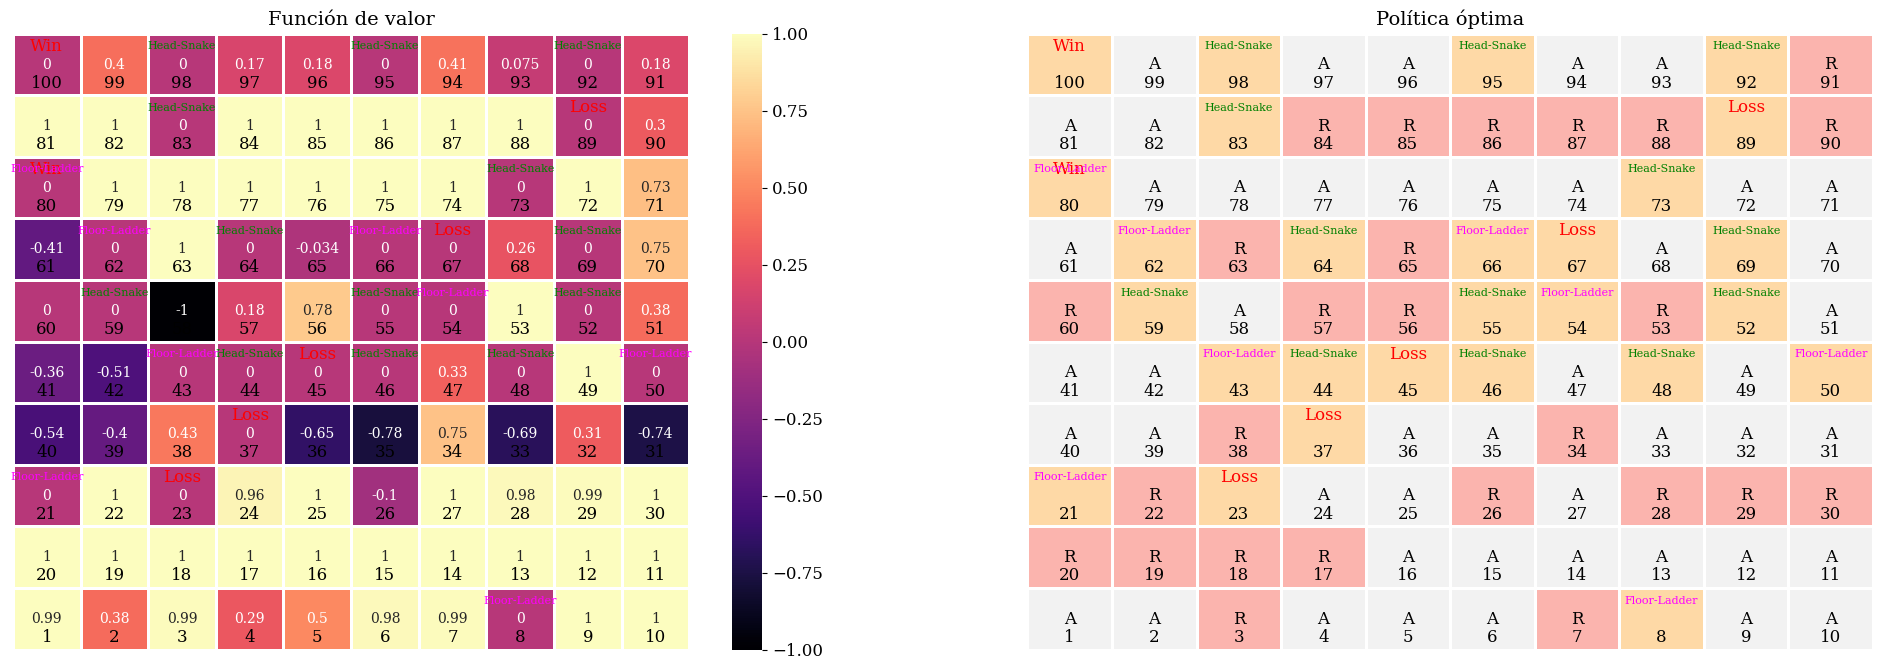

In [15]:
matrixVs, matrixPolicy, matrixState = makeMatrixVs(VMax, piOptimalMC)
visualizatedPolicy(matrixVs, matrixState, matrixPolicy, piOptimalMC, indexRewardWin, indexRewardLoss, headSnakes, floorLadders)

In [16]:
numberGames = 1000
_, percentageWin = playPolicy(piOptimalMC, numberGames,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

In [17]:
print(f'Utilizando el método Montercarlo en 1000 partidas se gana un {percentageWin*100:0.2f}% de las veces')

Utilizando el método Montercarlo en 1000 partidas se gana un 90.70% de las veces


# Política óptima SARSA (On Policy)

<p align="justify">
El algoritmo SARSA (On Policy) significa "State-Action-Reward-State-Action", lo que indica que el agente aprende a partir de la experiencia en un paso tomando en cuenta el estado actual del entorno, la acción que tomó, la recompensa que observa en la transición y el siguiente estado y acción que eligió.

<p align="justify">
El proceso de entrenamiento de SARSA se realiza a través de cada episodio, el agente comienza en un estado inicial y toma una acción. El entorno responde con un nuevo estado y una recompensa. A partir de ahí, el agente elige su siguiente acción en función de su política de decisión actual, y el proceso se repite hasta que el agente llega a un estado terminal.

<p align="justify">
Durante cada episodio, el algoritmo SARSA actualiza la función de valor del agente, que estima el valor esperado de la recompensa futura en función del estado y la acción. La actualización se realiza a través de la siguiente fórmula:

$$Q(s,a) = Q(s,a) + \alpha (R + \gamma Q(s',a') - Q(s,a))$$

El siguiente algoritmo representa el funcionamiento de SARSA:
```
Inicialice Q(s, a) ∈  0 ∀s ∈ S; Q(Terminal,.) = 0
Repetir para cada episodio:                        
  S ← inicializa en un estado
  Escoja A de A(S), de acuerdo a Q (ϵ − greedy)
  Repetir:
    Tomar A, observe S',R
    Escoja A de A(S), de acuerdo a Q (ϵ − greedy)
    Q(S, A) ← Q(S, A) + α [R+γ*Q(S′, A′) − Q(S, A)]
    S ← S′
    A ← A′

``` 

## Implementación del algoritmo

<p align="justify">
La siguiente función implementa el algoritmo, el cual recibe tres parámetros: $\alpha$, $\epsilon$ y $\gamma$. Utilizando esta función, se llevará a cabo la sintonización de los hiperparámetros $\alpha$ y $\epsilon$ para tres valores distintos de cada uno. El parámetro $\gamma$ será fijado en $0.95$. Aunque este factor se utiliza para el descuento de la recompensa en tareas no episódicas, en este caso se considera que su valor cercano a $1$ puede contribuir a una difusión suave de la recompensa para el cálculo del retorno.

In [18]:
def SARSA(alpha, epsilon, gamma, numberIterations):
  
  # Inicializar q(s,a) 
  Q = {}
  for s in boardState:
    for a in actionAvailable:
        Q[(s,a)] = 0

  numberActions = len(actionAvailable)

  # Ciclo del método 
  for _ in range(numberIterations):
    S = 1 # Inicializar en el estado 1 del tablero de juego 

    # Tomar A e-greedy
    indexActionGreedy = np.argmax([Q[(S,action)] for action in actionAvailable]) # accion greedy respecto a Q
    probabilitiesAction = (epsilon/numberActions)*np.ones((numberActions)) # vector con probabilidades e/k para todas 
    probabilitiesAction[indexActionGreedy] = 1-epsilon + (epsilon/numberActions) # le pongo a la accion greedy 1-e + e/k
    A = random.choices(actionAvailable, weights=probabilitiesAction, k=1)[0] # Tomo A 

    while True:
      # Tomar A, ver S' y R
      SNew, R, flag = playGame(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

      # Hacer A' greedy con Q
      indexActionGreedy = np.argmax([Q[(SNew,action)] for action in actionAvailable]) # accion greedy respecto a Q
      probabilitiesAction = (epsilon/numberActions)*np.ones((numberActions)) # vector con probabilidades e/k para todas 
      probabilitiesAction[indexActionGreedy] = 1-epsilon + (epsilon/numberActions) # le pongo a la accion greedy 1-e + e/k
      ANew = random.choices(actionAvailable, weights=probabilitiesAction, k=1)[0] # Tomo A  
      
      Q[(S,A)] += alpha*(R + gamma*(Q[(SNew, ANew)])- Q[(S,A)]) # Regla de actualización 

      S = SNew
      A = ANew

      if flag: break;
  # Hacer greedy la función Q[(s,a)] para todos los pares y conseguir v(s) optima
  piOptimalSARSA = {}
  VMax = {}
  for s in boardState:
    if s in headSnakes or s in floorLadders or s in indexRewardLoss or s in indexRewardWin:
      piOptimalSARSA[s] = 'NA'
      VMax[s] = 0
    else:  
      Qmax = [Q[(s,action)] for action in actionAvailable]
      actionBetter = actionAvailable[np.argmax(Qmax)]
      piOptimalSARSA[s] = actionBetter
      VMax[s] = max(Qmax)
  return piOptimalSARSA, VMax

<p align="justify">
En esta instancia se está llevando a cabo una búsqueda de hiperparámetros con el fin de encontrar los valores óptimos de $\alpha$ y $\epsilon$ para el algoritmo de SARSA. Para ello, se han definido tres valores distintos para cada uno de estos hiperparámetros, lo que resulta en un total de nueve combinaciones que se evaluarán exhaustivamente. Una vez que se ha generado cada combinación y se ha obtenido la política óptima $\pi$, es necesario comprobar su efectividad en un conjunto de pruebas. Para ello, se ejecutan varias partidas del juego y se miden dos aspectos fundamentales del rendimiento de la política óptima: el porcentaje de victorias y la longitud promedio de las partidas. 

In [19]:
alphas = [0.1, 0.6, 0.9]
epsilons = [0.1, 0.15, 0.2]
gamma = 0.95
numberIterations = 10000
numberGames = 100

percentageWins = np.zeros((3, 3))
meanLenSets = np.zeros((3, 3))

j = 0
for alpha in alphas:
  i = 0
  for epsilon in epsilons:
    policyQ, _ = SARSA(alpha, epsilon, gamma, numberIterations)
    print(f'Modelo alpha: {alpha}, epsilon: {epsilon}, finalizado')
    lenSets, percentageWin = playPolicy(policyQ, numberGames,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
    print(f'Modelo alpha: {alpha}, epsilon: {epsilon}, 100 partidas jugadas')
    percentageWins[i][j] = percentageWin
    meanLenSets[i][j] = np.mean(lenSets)
    i += 1
  j += 1

Modelo alpha: 0.1, epsilon: 0.1, finalizado
Modelo alpha: 0.1, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.1, epsilon: 0.15, finalizado
Modelo alpha: 0.1, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.1, epsilon: 0.2, finalizado
Modelo alpha: 0.1, epsilon: 0.2, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.1, finalizado
Modelo alpha: 0.6, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.15, finalizado
Modelo alpha: 0.6, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.2, finalizado
Modelo alpha: 0.6, epsilon: 0.2, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.1, finalizado
Modelo alpha: 0.9, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.15, finalizado
Modelo alpha: 0.9, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.2, finalizado
Modelo alpha: 0.9, epsilon: 0.2, 100 partidas jugadas


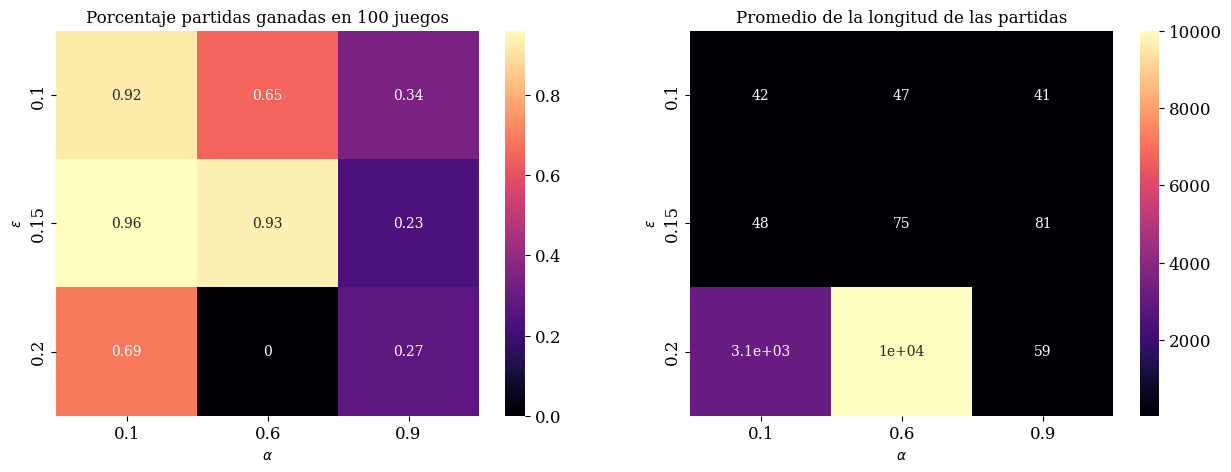

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(percentageWins, cmap='magma', ax = ax[0], annot = True)
sns.heatmap(meanLenSets, cmap='magma', ax = ax[1], annot = True)

ax[0].set_xticklabels(alphas)
ax[0].set_yticklabels(epsilons)
ax[0].set_xlabel('$\\alpha$')
ax[0].set_ylabel('$\epsilon$')
ax[0].set_title('Porcentaje partidas ganadas en 100 juegos')

ax[1].set_xticklabels(alphas)
ax[1].set_yticklabels(epsilons)
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('$\epsilon$')
ax[1].set_title('Promedio de la longitud de las partidas')
plt.show()

<p align="justify">
Al analizar los mapas de calor, se puede observar que los valores que muestran un mejor desempeño en el método son $\alpha = 0.1$ y $\epsilon = 0.15$. Con esta configuración de hiperparámetros, se logra un porcentaje de partidas ganadas del 96% en 100 juegos. Aunque no es la configuración que minimiza la longitud promedio de los episodios, su valor también es adecuado con un promedio por partida de 48 pasos. A continuación, se realiza otra ejecución del método con estos mismos valores de hiperparámetros, pero con un total de 80000 iteraciones y se visualiza la función de valor y la política encontrada. 

In [21]:
alpha = 0.1
epsilon = 0.15
gamma = 0.95 
numberIterations = 80000

piOptimalSARSA, VMax = SARSA(alpha, epsilon, gamma, numberIterations)

## Visualización de política

<p align="justify">
A continuación se presentan en mapas de calor la función $V_{\star}$ y la política óptima estimada. Con esta política se realizan 1000 partidas del juego y se calcula el porcentaje de victorias.

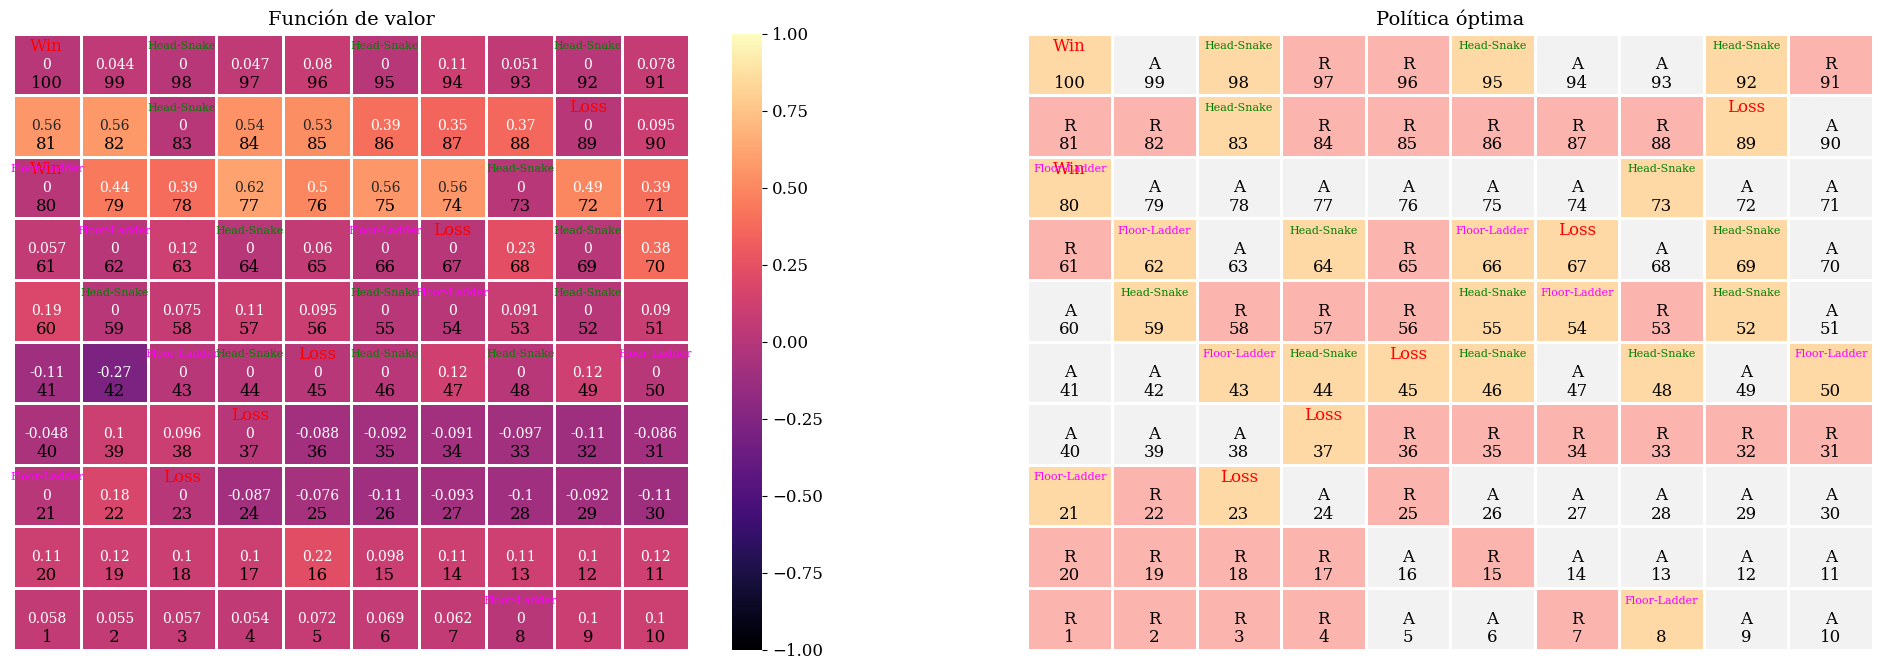

In [22]:
matrixVs, matrixPolicy, matrixState = makeMatrixVs(VMax, piOptimalSARSA)
visualizatedPolicy(matrixVs, matrixState, matrixPolicy, piOptimalSARSA, indexRewardWin, indexRewardLoss, headSnakes, floorLadders)

In [23]:
numberGames = 1000
_, percentageWin = playPolicy(piOptimalSARSA, numberGames,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

In [24]:
print(f'Utilizando el método SARSA en 1000 partidas se gana un {percentageWin*100:0.2f}% de las veces')

Utilizando el método SARSA en 1000 partidas se gana un 96.40% de las veces


# Política óptima Q-learning

<p align="justify">
El algoritmo de Q-learning es una técnica de aprendizaje por refuerzo que se utiliza para determinar la mejor acción que un agente debe tomar en cada estado para maximizar su recompensa a largo plazo. La política óptima se calcula utilizando la estimación de la función de valor óptima para los pares estado-acción, denotada como $Q_{\star}(s,a)$
El proceso de estimación de esta función se realiza mediante la técnica de "bootstraping", lo que significa que la regla de actualización utiliza estimaciones previas de los valores de $Q_{\star}(s,a)$ para actualizar su estimación actual, o de estimaciones para los estados siguientes ($Q(s',a')$).

La actualización para algun par $(s,a)$ se realiza:

$$Q(s,a) = Q(s,a) + \alpha (R + \gamma \max_{a'}(Q(s',a')) - Q(s,a))$$
<p align="justify">
donde $R$ es la recompensa obtenida al tomar la acción $a$ en el estado $s$, $s'$ es el estado siguiente, $\alpha$ es la tasa de aprendizaje y $\gamma$ es el factor de descuento. Incluir el término $\max_{a'}(Q(s',a'))$ en la actualización implica no utilizar la misma política que esta siguiendo $Q$, si no una acción greedy, por esta razón el algoritmo Q-learning es de caracter off-policy. Despues de varias iteraciones del algoritmo la función $Q(s,a), \forall s, a$ converge a $Q_{\star}(s,a), \forall s, a$ si todos los pares $s,a$ se visitan frecuentemente. 

El algoritmo de Q-learning se detalla a continuación: 

```
Inicialice Q(s, a) ∈  0 ∀s ∈ S; Q(Terminal,.)=0
Repetir para cada episodio:
  S ← inicializa en un estado
  Repetir para cada paso del episodio:
    Escoja A de A(S), de acuerdo a Q (ϵ − greedy)
    Tomar A, observe S',R
    Q(S, A) ← Q(S, A) + α [R+γ*Max_{a'}(Q(S′, a′)) − Q(S,A)]
    S ← S′

``` 

## Implementación del algoritmo


<p align="justify">
La siguiente función implementa el algoritmo, el cual recibe tres parámetros: $\alpha$, $\epsilon$ y $\gamma$. Utilizando esta función, se llevará a cabo la sintonización de los hiperparámetros $\alpha$ y $\epsilon$ para tres valores distintos de cada uno. El parámetro $\gamma$ será fijado en $0.95$. Aunque este factor se utiliza para el descuento de la recompensa en tareas no episódicas, en este caso se considera que su valor cercano pero no estrictamente $1$ puede contribuir a una difusión suave de la recompensa para el cálculo del retorno.

In [25]:
def Qlearning(alpha, epsilon, gamma, numberIterations):
  # Esta función realiza el algoritmo SARSA y encuentra la política óptima 
  # despues de un numero de iteraciones. La función requiere la función playPolicy 
  # para esto deberan estar cargados todos los elementos que a su vez requiere playPolicy

  # alpha = tasa de aprendizaje
  # gamma = factor de descuento de la recompensa
  # epsilon = valor epsilon para la selección de la política e-greedy


  # Inicializar q(s,a) 
  Q = {}
  for s in boardState:
    for a in actionAvailable:
        Q[(s,a)] = 0

  numberActions = len(actionAvailable)

  # Ciclo del método 
  for _ in range(numberIterations):
    S = 1 # Inicializar algun en la posición 1 del tablero de juego 
    while True:

      # Hacer A e-greedy (podría ser cualquier otra política que explore)
      indexActionGreedy = np.argmax([Q[(S,action)] for action in actionAvailable]) # accion greedy respecto a Q
      probabilitiesAction = (epsilon/numberActions)*np.ones((numberActions)) # vector con probabilidades e/k para todas 
      probabilitiesAction[indexActionGreedy] = 1-epsilon + (epsilon/numberActions) # agregar a la accion greedy 1-e + e/k
      A = random.choices(actionAvailable, weights=probabilitiesAction, k=1)[0] # Tomar A 
      
      # Tomar A, observar nuevo estado SNew y la recompensa en la transición 
      SNew, R, flag = playGame(S,A, gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
      
      # Hacer greedy respecto a Q la política en el estado SNew
      maxA = max([Q[(SNew,a)] for a in actionAvailable]) 
      
      # Regla de actualización 
      Q[(S,A)] += alpha*(R + gamma*(maxA)- Q[(S,A)]) 

      S = SNew

      if flag: break;
  
  # Hacer greedy la función Q[(s,a)] para todos los pares y conseguir v(s) optima
  piOptimalQlearning = {}
  VMax = {}
  for s in boardState:
    if s in headSnakes or s in floorLadders or s in indexRewardLoss or s in indexRewardWin:
      piOptimalQlearning[s] = 'NA'
      VMax[s] = 0
    else:  
      Qmax = [Q[(s,action)] for action in actionAvailable]
      actionBetter = actionAvailable[np.argmax(Qmax)]
      piOptimalQlearning[s] = actionBetter
      VMax[s] = max(Qmax)
  return piOptimalQlearning, VMax

<p align="justify">
En este caso particular, se está considerando una búsqueda de hiperparámetros con una variación de 3 valores para $\alpha$ y $\epsilon$, lo que resultará en 9 combinaciones de hiperparámetros que serán evaluadas. Una vez que se han generado todas las combinaciones de hiperparámetros y se encuentra la política óptima $\pi$ correspondiente, se debe evaluar su rendimiento en un conjunto de pruebas. Para esto, se realizan varias partidas del juego y se observa el porcentaje de victorias obtenidas por la política óptima y la longitud promedio de las partidas.

In [26]:
alphas = [0.1, 0.6, 0.9] # Valores para alpha
epsilons = [0.1, 0.15, 0.2] # Valores para epsillon
gamma = 0.95
numberIterations = 10000
numberGames = 100

percentageWins = np.zeros((3, 3))
meanLenSets = np.zeros((3, 3))

j = 0
for alpha in alphas:
  i = 0
  for epsilon in epsilons:
    policyQ, _ = Qlearning(alpha, epsilon, gamma, numberIterations)
    print(f'Modelo alpha: {alpha}, epsilon: {epsilon}, finalizado')
    lenSets, percentageWin = playPolicy(policyQ, numberGames,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
    print(f'Modelo alpha: {alpha}, epsilon: {epsilon}, 100 partidas jugadas')
    percentageWins[i][j] = percentageWin
    meanLenSets[i][j] = np.mean(lenSets)
    i += 1
  j += 1

Modelo alpha: 0.1, epsilon: 0.1, finalizado
Modelo alpha: 0.1, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.1, epsilon: 0.15, finalizado
Modelo alpha: 0.1, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.1, epsilon: 0.2, finalizado
Modelo alpha: 0.1, epsilon: 0.2, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.1, finalizado
Modelo alpha: 0.6, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.15, finalizado
Modelo alpha: 0.6, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.6, epsilon: 0.2, finalizado
Modelo alpha: 0.6, epsilon: 0.2, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.1, finalizado
Modelo alpha: 0.9, epsilon: 0.1, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.15, finalizado
Modelo alpha: 0.9, epsilon: 0.15, 100 partidas jugadas
Modelo alpha: 0.9, epsilon: 0.2, finalizado
Modelo alpha: 0.9, epsilon: 0.2, 100 partidas jugadas


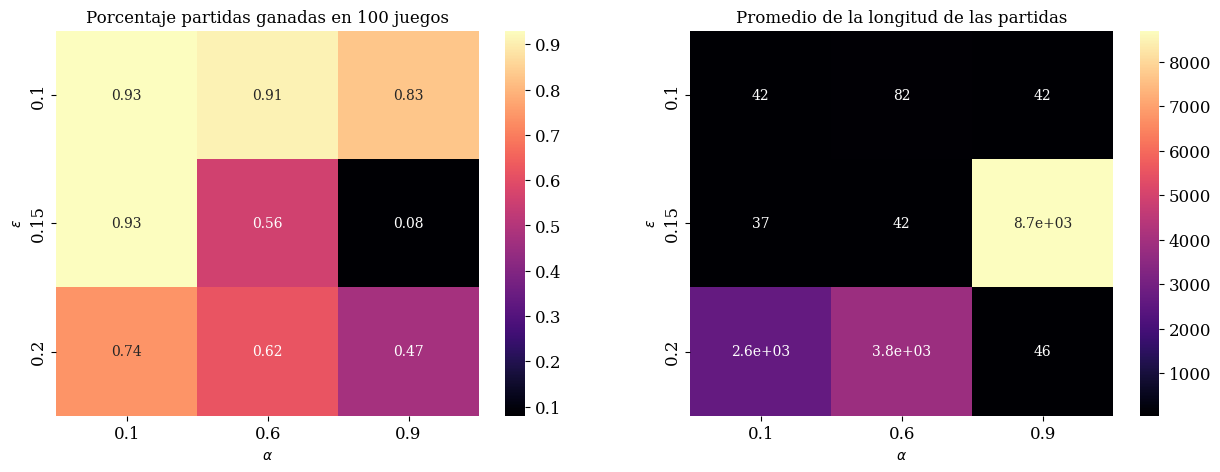

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(percentageWins, cmap='magma', ax = ax[0], annot = True)
sns.heatmap(meanLenSets, cmap='magma', ax = ax[1], annot = True)

ax[0].set_xticklabels(alphas)
ax[0].set_yticklabels(epsilons)
ax[0].set_xlabel('$\\alpha$')
ax[0].set_ylabel('$\epsilon$')
ax[0].set_title('Porcentaje partidas ganadas en 100 juegos')

ax[1].set_xticklabels(alphas)
ax[1].set_yticklabels(epsilons)
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('$\epsilon$')
ax[1].set_title('Promedio de la longitud de las partidas')
plt.show()

<p align="justify">
Al analizar los mapas de calor, se puede observar que los valores que muestran un mejor desempeño en el método son $\alpha = 0.1$ y $\epsilon = 0.15$. Con esta configuración de hiperparámetros, se logra un porcentaje de partidas ganadas del 93% en 100 juegos y una longitud promedio de episodios de 37 pasos. A continuación, se realiza otra ejecución del método con estos mismos valores de hiperparámetros, pero con un total de 80000 iteraciones y se visualiza la función de valor y la política encontrada. 

In [28]:
alpha = 0.1
epsilon = 0.15
gamma = 0.95
numberIterations = 80000

piOptimalQlearning, VMax = Qlearning(alpha, epsilon, gamma, numberIterations)

## Visualización de la política

<p align="justify">
A continuación se presentan en mapas de calor la función $V_{\star}$ y la política óptima estimada. Con esta política se realizan 1000 partidas del juego y se calcula el porcentaje de victorias. 

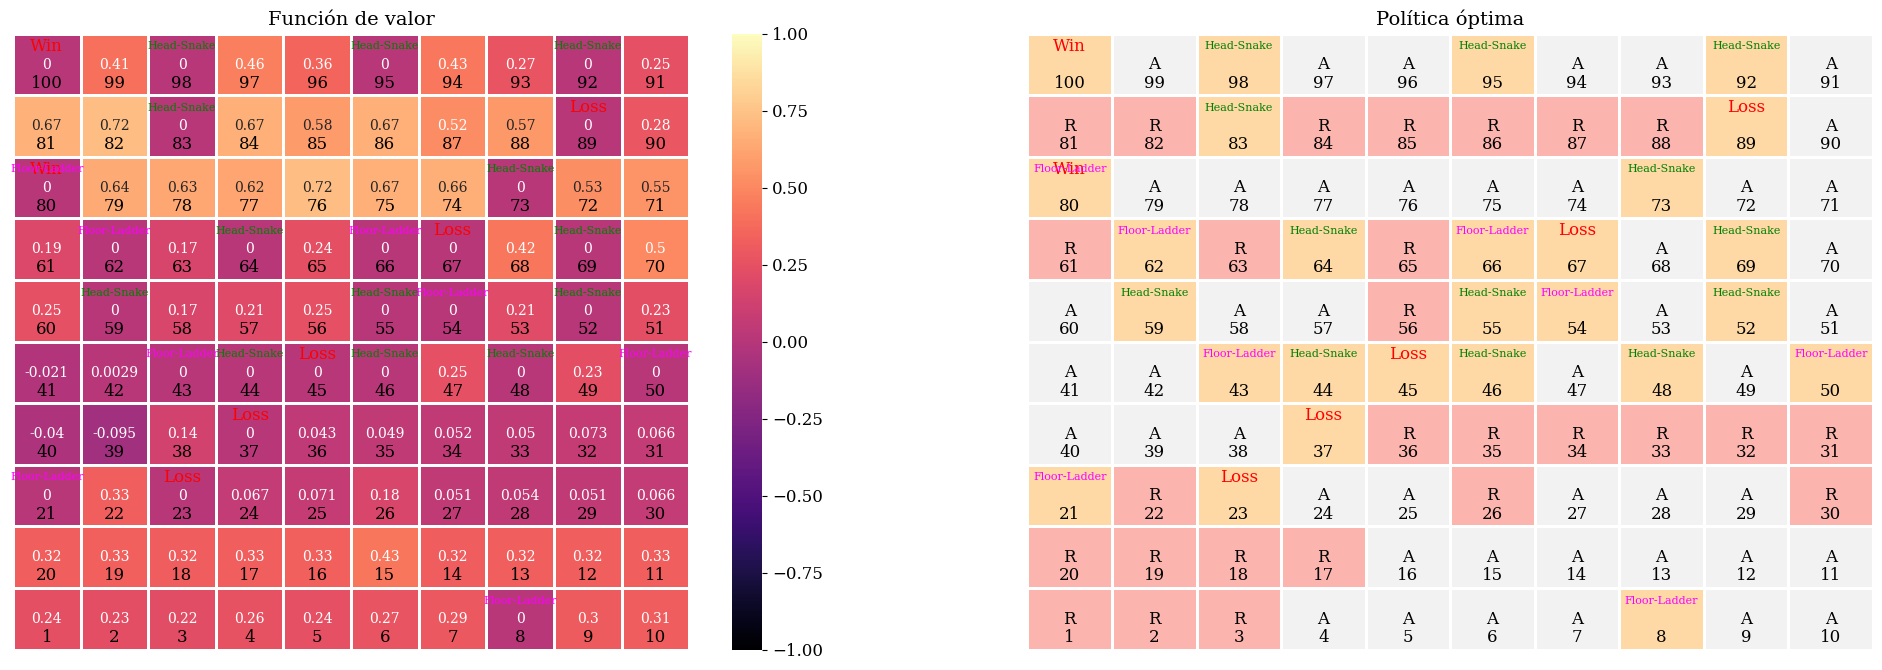

In [29]:
matrixVs, matrixPolicy, matrixState = makeMatrixVs(VMax, piOptimalQlearning)
visualizatedPolicy(matrixVs, matrixState, matrixPolicy, piOptimalQlearning, indexRewardWin, indexRewardLoss, headSnakes, floorLadders)

In [30]:
numberGames = 1000
_, percentageWin = playPolicy(piOptimalQlearning, numberGames,
                             gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

In [31]:
print(f'Utilizando el método Qlearning en 1000 partidas se gana un {percentageWin*100:0.2f}% de las veces')

Utilizando el método Qlearning en 1000 partidas se gana un 94.40% de las veces


# Evaluación de los métodos

In [32]:
numberGames = 1000

stepMC,winMC = playPolicy(piOptimalMC, numberGames, 
                                        gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
stepSARSA, winSARSA = playPolicy(piOptimalSARSA, numberGames, 
                                  gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)
stepQlearning, winQlearning = playPolicy(piOptimalQlearning, numberGames,
                                            gameOver, headSnakes, tailSnakes, floorLadders, ceilLadders, rewardBoard)

In [33]:
print(f'Montercarlo:\nEl método Montecarlo off-policy logra un porcentaje de partidas ganadas de {winMC*100:0.2f} en {numberGames} partidas y la longitud promedio de las partidas fue {np.mean(stepMC)}')
print(f'\n\nSARSA:\nEl método SARSA logra un porcentaje de partidas ganadas de {winSARSA*100:0.2f} en {numberGames} partidas y la longitud promedio de las partidas fue {np.mean(stepSARSA)}')
print(f'\n\nQ-learning:\nEl método Q-learning logra un porcentaje de partidas ganadas de {winQlearning*100:0.2f} en {numberGames} partidas y la longitud promedio de las partidas fue {np.mean(stepQlearning)}')

Montercarlo:
El método Montecarlo off-policy logra un porcentaje de partidas ganadas de 87.90 en 1000 partidas y la longitud promedio de las partidas fue 78.63


SARSA:
El método SARSA logra un porcentaje de partidas ganadas de 96.20 en 1000 partidas y la longitud promedio de las partidas fue 78.4


Q-learning:
El método Q-learning logra un porcentaje de partidas ganadas de 94.30 en 1000 partidas y la longitud promedio de las partidas fue 36.892


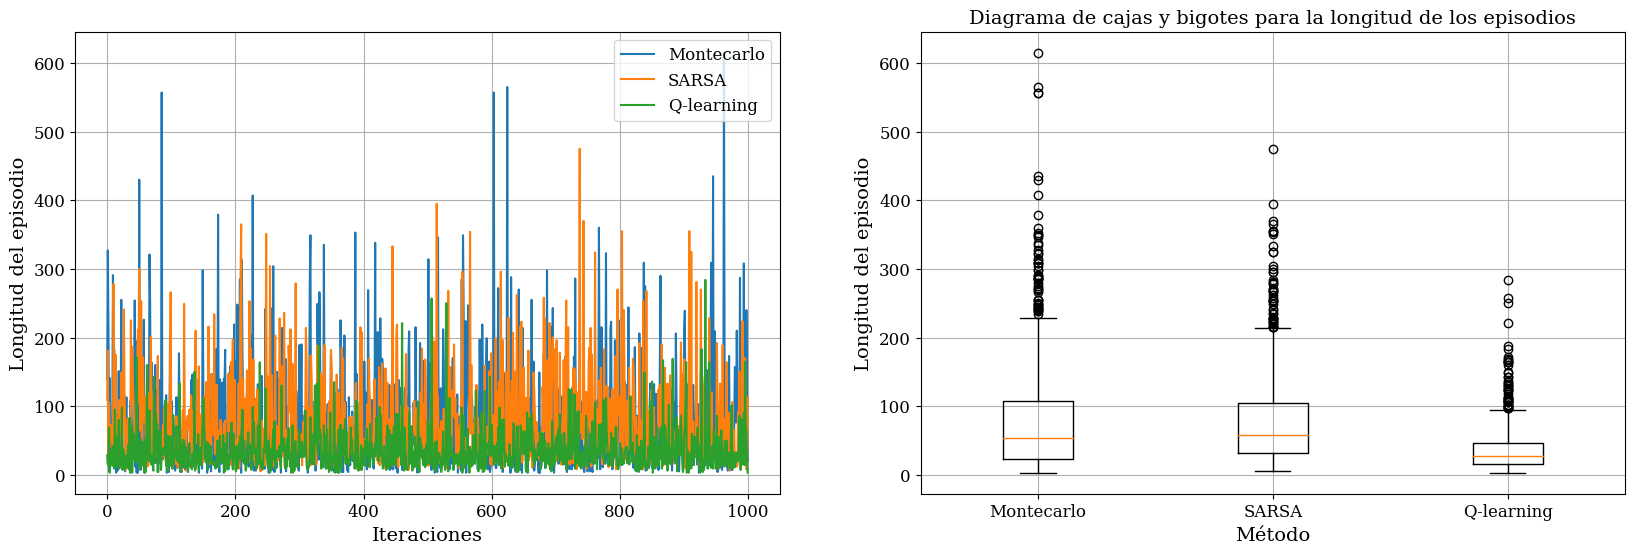

In [34]:
fig, ax = plt.subplots(1,2, figsize=(20,6))

# Gráfica de la longitud de los episodios
ax[0].plot(stepMC, label=f'Montecarlo')
ax[0].plot(stepSARSA, label=f'SARSA')
ax[0].plot(stepQlearning, label=f'Q-learning')
ax[0].set_ylabel('Longitud del episodio', fontsize = 14)
ax[0].set_xlabel('Iteraciones', fontsize = 14)
ax[0].legend(fontsize=12)
ax[0].grid()

# Gráfica diagráma boxplot de la longitud de los episodios

# Gráfica diagráma boxplot de la recompensa promedio para cada epsilon 
lenByMethod = {}
lenByMethod['Montecarlo'] = stepMC
lenByMethod['SARSA'] = stepSARSA
lenByMethod['Q-learning'] = stepQlearning
method, lens = [lenByMethod.keys()], lenByMethod.values()
ax[1].boxplot(lens)

# Configuración aspecto de la gráfica boxplot
ax[1].set_title(f'Diagrama de cajas y bigotes para la longitud de los episodios', fontsize = 14)
ax[1].set_ylabel('Longitud del episodio', fontsize = 14)
ax[1].set_xlabel('Método', fontsize = 14)
ax[1].set_xticklabels(['Montecarlo', 'SARSA', 'Q-learning'])
ax[1].grid()

#Conclusiones

<p align="justify">
- Luego de analizar los resultados obtenidos en 1000 partidas de juego, se puede concluir que el método SARSA presenta un mejor desempeño, alcanzando una tasa de victorias del 96.2%. Aunque el método Q-learning también tiene un buen rendimiento, con una tasa de victorias del 94.3%, se observa que SARSA logra una ventaja significativa en la mayoría de las partidas. Por otro lado, el método de Monte Carlo obtiene resultados inferiores, con una tasa de victorias de aproximadamente 88%, lo que sugiere que este método puede requerir más iteraciones para converger. Es importante señalar que, dado que todos los métodos se evaluaron con el mismo número de iteraciones en el marco experimental del taller, es posible que Montecarlo pueda obtener resultados más cercanos a los de SARSA y Q-learning si se le permite un mayor número de iteraciones. En resumen, los resultados sugieren que SARSA y Q-learning son opciones sólidas para resolver el problema de aprendizaje por refuerzo en este contexto específico, y que Montecarlo podría ser una alternativa válida si se le brinda más tiempo para converger.
<p align="justify">
- En cuanto a la duración promedio de las partidas, se puede observar que Q-learning presenta una menor cantidad de movimientos, con un promedio de 36.9 pasos. En el caso de SARSA y Montecarlo, se tiende a una mayor cantidad de pasos, con un promedio combinado de alrededor de 78 pasos. Este comportamiento puede relacionarse con la naturaleza de los métodos. En el caso de Montecarlo off-policy, se está ejecutando una política aleatoria que constantemente tiene que explorar, lo que puede llevar a episodios más largos mientras se busca la política óptima. Aunque la política óptima estimada es diferente a la de comportamiento, el número de iteraciones y la naturaleza de la política de comportamiento podrían generar una política que requiera más pasos para terminar las partidas. Por su parte, el método SARSA es de carácter on-policy, lo que significa que se encuentra una política óptima en un espacio acotado de posibles políticas, restringiéndose solamente a las políticas suaves que permitan explorar. Esta característica puede generar que la política encontrada requiera más pasos para finalizar las partidas. Por otro lado, en Q-learning se realiza una política greedy y se estima en todo el espacio de posibles políticas, este método puede tender a generar políticas con desiciónes arriesgadas, es decir prefiere ganar que no perder lo que puede explicar la menor cantidad de movimientos promedio necesarios para finalizar las partidas. 
<p align="justify">
- En el diagrama de cajas y bigotes que representa la longitud de las partidas, se puede apreciar que el método de Monte Carlo es el que presenta una mayor cantidad de valores atípicos, incluso con episodios de más de 600 pasos. Este comportamiento también se puede observar en la gráfica por jugadas. Por otro lado, tanto SARSA como Montecarlo concentran la mayoría de las partidas por debajo de 100 pasos, con una media similar. En el caso de Q-learning, se puede notar que la variabilidad de los datos es menor, con la mayoría de las partidas con una cantidad de pasos más estable en comparación con SARSA y Montecarlo.
<p align="justify">
- Se puede destacar que en la elección de hiperparámetros, se ha observado una correlación entre el número de estados necesarios para alcanzar un estado terminal y el porcentaje de victorias en el juego. Sin embargo, se ha verificado que no siempre el método con el menor número de pasos es el que obtiene la mayor tasa de victorias. Este hallazgo se confirma en los resultados obtenidos por los tres métodos evaluados, donde a pesar de que Q-learning requiere menos pasos para finalizar las partidas, no logra obtener la tasa de victorias más alta.
<p align="justify">
- En los métodos de SARSA y Q-learning, la elección de los parámetros $\alpha$ y $\epsilon$ es crucial para su correcto desempeño, como se evidenció en los mapas de calor utilizados para la sintonización de estos elementos. En algunos casos, una mala configuración de estos parámetros puede generar políticas que caen en ciclos, no logran finalizar las partidas o producen partidas extremadamente largas. En este taller se realizaron pruebas para nueve configuraciones posibles, sin embargo, se recomienda realizar una búsqueda más exhaustiva y posteriormente una sintonización fina sobre una configuración con buenos resultados. Otro aspecto relevante en estos métodos es la inicialización de la función $Q(s,a)$. Aunque se sabe que para los estados terminales debe ser 0 y permanecer así por definición, no está claro cómo inicializar correctamente esta función. Dado que ambos métodos realizan bootstrapping, pueden ser sensibles a una inicialización inadecuada de estos valores.
<p align="justify">
- La evaluación de los resultados obtenidos en este experimento se basó en una sola instancia experimental, lo que puede limitar la generalización de las conclusiones obtenidas. Para una evaluación más rigurosa y confiable, se recomienda repetir el experimento múltiples veces, con 1000 partidas cada vez, y llevar a cabo un análisis estadístico para verificar la significancia de las métricas obtenidas. De esta manera, se podría determinar si los resultados obtenidos son consistentes y replicables en diferentes escenarios, y se podrían obtener conclusiones más sólidas y generalizables. 
